# CNN Implementation for a Sketch Classifier

### downloading the data and installing dependencies

In this implementation, I use the version of the QuickDraw dataset where each doodle is rendered as a 28x28 grayscale bitmap image. This format works well for CNNs and allows us to treat the sketches similarly other popular data like MNIST

In [ ]:
!/home/sohaila/google-cloud-sdk/bin/gsutil -m cp 'gs://quickdraw_dataset/full/numpy_bitmap/cat.npy' .
!/home/sohaila/google-cloud-sdk/bin/gsutil -m cp 'gs://quickdraw_dataset/full/numpy_bitmap/tree.npy' .
!/home/sohaila/google-cloud-sdk/bin/gsutil -m cp 'gs://quickdraw_dataset/full/numpy_bitmap/fish.npy' .
!/home/sohaila/google-cloud-sdk/bin/gsutil -m cp 'gs://quickdraw_dataset/full/numpy_bitmap/clock.npy' .
!/home/sohaila/google-cloud-sdk/bin/gsutil -m cp 'gs://quickdraw_dataset/full/numpy_bitmap/castle.npy' .
!/home/sohaila/google-cloud-sdk/bin/gsutil -m cp 'gs://quickdraw_dataset/full/numpy_bitmap/crown.npy' .
!/home/sohaila/google-cloud-sdk/bin/gsutil -m cp 'gs://quickdraw_dataset/full/numpy_bitmap/lollipop.npy' .
!/home/sohaila/google-cloud-sdk/bin/gsutil -m cp 'gs://quickdraw_dataset/full/numpy_bitmap/moon.npy' .
!/home/sohaila/google-cloud-sdk/bin/gsutil -m cp 'gs://quickdraw_dataset/full/numpy_bitmap/watermelon.npy' .
!/home/sohaila/google-cloud-sdk/bin/gsutil -m cp 'gs://quickdraw_dataset/full/numpy_bitmap/tornado.npy' .
!/home/sohaila/google-cloud-sdk/bin/gsutil -m cp 'gs://quickdraw_dataset/full/numpy_bitmap/apple.npy' .
!/home/sohaila/google-cloud-sdk/bin/gsutil -m cp 'gs://quickdraw_dataset/full/numpy_bitmap/bowtie.npy' .
!/home/sohaila/google-cloud-sdk/bin/gsutil -m cp 'gs://quickdraw_dataset/full/numpy_bitmap/bicycle.npy' .
!/home/sohaila/google-cloud-sdk/bin/gsutil -m cp 'gs://quickdraw_dataset/full/numpy_bitmap/diamond.npy' .
!/home/sohaila/google-cloud-sdk/bin/gsutil -m cp 'gs://quickdraw_dataset/full/numpy_bitmap/flower.npy' .
!/home/sohaila/google-cloud-sdk/bin/gsutil -m cp 'gs://quickdraw_dataset/full/numpy_bitmap/butterfly.npy' .
!/home/sohaila/google-cloud-sdk/bin/gsutil -m cp 'gs://quickdraw_dataset/full/numpy_bitmap/eye.npy' .
!/home/sohaila/google-cloud-sdk/bin/gsutil -m cp 'gs://quickdraw_dataset/full/numpy_bitmap/lightning.npy' .
!/home/sohaila/google-cloud-sdk/bin/gsutil -m cp 'gs://quickdraw_dataset/full/numpy_bitmap/cloud.npy' .
!/home/sohaila/google-cloud-sdk/bin/gsutil -m cp 'gs://quickdraw_dataset/full/numpy_bitmap/pizza.npy' .

In [ ]:
%pip install ndjson
%pip install torch
%pip install torchvision

### visualizing the data to familiarize ourselves with it

Shape: (123202, 784)


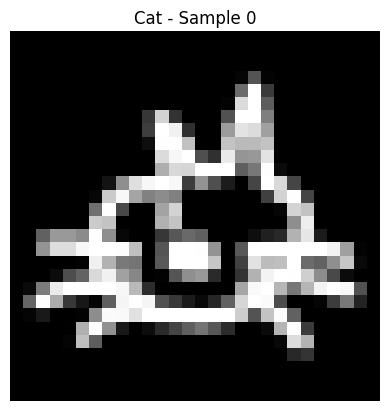

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#loading the .npy file for the "cat" category
data = np.load("data/cat.npy")
#printing the shape of the data
print("Shape:", data.shape)

#reshaping the image back to its 28x28 form for viewing
img = data[0].reshape(28, 28)

#visualizing the image
plt.imshow(img, cmap='gray')
plt.title("Cat - Sample 0")
plt.axis('off')
plt.show()


# Data Preparation

Below, we will create a custom dataset class to be able to work with our data. We will also visualize the data and its shape

*Note to self: we've previously worked with data that was already provided in torchvision; this time we're working with custom data, so we need to define our own custom dataset class to handle loading and transforming the data properly*

In [2]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

In [3]:
# Custom dataset class for QuickDraw .npy files
# Each file contains many 28x28 grayscale images for a single category
# This dataset class will load the images and labels, apply transformation, and provide a way to access individual samples
class QuickDrawDataset(Dataset):

    def __init__(self, file_paths, labels, transform=None, max_per_class=10000):
        """
        file_paths (list of str): List of .npy file paths (one per class)
        labels (list of int): Corresponding class labels for each file
        transform (torchvision.transforms): Image transformations to apply
        max_per_class (int): Max number of samples to load per class
        """

        self.data = [] #to store all images from all categories
        self.targets = [] #to store corresponding labels
        self.transform = transform

        #loading each class
        for path, label in zip(file_paths, labels):
            images = np.load(path)[:max_per_class] #only take max_per_class samples per class
            self.data.append(images) #add the images to the data
            self.targets += [label] * len(images) #add corresponding labels for each sample to the targets list

        #flattening the list of arrays into a single numpy array (shape: [total_samples, 784] -> since each image is 28x28 flattened to 784 pixels)
        self.data = np.concatenate(self.data, axis=0)       # shape: (total_samples, 784)
        #converting the list of labels into a PyTorch tensor (shape: [total_samples,]) -> so that it's compatible with input/output of python models
        self.targets = torch.tensor(self.targets)


    def __len__(self):
        #return the number of samples in the dataset
        return len(self.targets)

    def __getitem__(self, idx):
        """
        Retrieves a single image and label pair at the specified index
        """
        #get flattened image (784 values) and reshape to 28x28
        img = self.data[idx].reshape(28, 28).astype(np.uint8) #self.data[idx] gets the idx-th row, which is a 1D array of 784 values, ie one flattened image

        #convert to PIL Image so we can apply torchvision transforms
        img = Image.fromarray(img)

        #apply transform
        if self.transform:
            img = self.transform(img)

        #return image tensor and its corresponding label
        return img, self.targets[idx]


In [4]:
#for transformations, we just want to convert each image (numpy array) into a pytorch tensor
transform = transforms.Compose([
    transforms.ToTensor(),
])

#all the class/label names
label_names = [
    'cat', 'tree', 'fish', 'clock', 'castle', 'crown', 'lollipop', 'moon',
    'watermelon', 'tornado', 'apple', 'bowtie', 'bicycle', 'diamond',
    'flower', 'butterfly', 'eye', 'lightning', 'cloud', 'pizza'
]

#building file paths from class names
file_paths = [f"data/{name}.npy" for name in label_names]

#creating label indices
labels = list(range(len(label_names)))

#loading the full dataset
full_dataset = QuickDrawDataset(file_paths, labels, transform=transform, max_per_class=10000)

#define split sizes for 80/10/10 split for train/dev/test sets
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
dev_size = int(0.1 * total_size)
test_size = total_size - train_size - dev_size  # Ensures full coverage

#randomly split the dataset
train_dataset, dev_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, dev_size, test_size]
)

#create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#print sizes to confirm
print(f"Total size: {len(full_dataset)}")
print(f"Train size: {len(train_dataset)}")
print(f"Dev size: {len(dev_dataset)}")
print(f"Test size: {len(test_dataset)}")

Total size: 200000
Train size: 160000
Dev size: 20000
Test size: 20000


In [5]:
#previewing a batch
images, targets = next(iter(train_loader)) #fetching the next batch from the train_loader (which gives a batch of images and labels)
#printing the shape of the image batch
print("Image batch shape:", images.shape) #expected: [batch_size, channels, height, width] -> [64, 1, 28, 28]
#printing the first 10 labels in the batch (these are just indices)
print("Label batch:", targets[:10])
#printing raw tensor values of the first image in the batch
print("Image:", images[0]) #most pixel values are zeros (black background) which makes sense when considering that they're all rough simple sketches

Image batch shape: torch.Size([64, 1, 28, 28])
Label batch: tensor([ 5, 12,  2, 10,  5,  1,  3, 19,  2, 19])
Image: tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.000

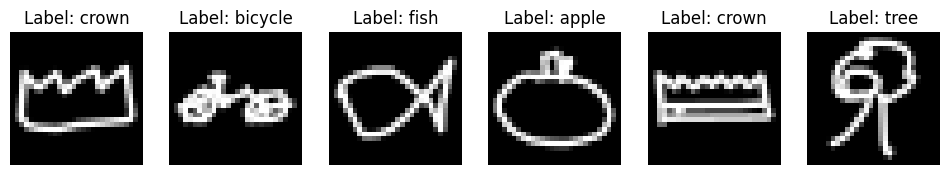

In [6]:
#plotting the first 6 images from the batch with their labels to again visualize the data and understand what we're working with
fig, axes = plt.subplots(1, 6, figsize=(12, 2))
for i in range(6):
    axes[i].imshow(images[i].squeeze(), cmap='gray') #plot the image
    label_idx = targets[i].item() #get the label index
    label_name = label_names[label_idx] #get the class name
    axes[i].set_title(f"Label: {label_name}") #print the label name
    axes[i].axis('off')
plt.show()


# Building the CNN Model

The CNN implemented here is inspired by classic architectures like AlexNet, but simplified to suit the QuickDraw dataset, which contains low-detail sketches. Since the input images are 28x28 grayscale images, the network begins with a convolutional layer that maps the single input channel to 8 feature maps using a 3x3 kernel with padding to preserve spatial dimensions. It then stacks additional convolutional layers with increasing depth (16 -> 32 -> 64), each followed by ReLU activations for non-linearity and MaxPooling layers to downsample the feature maps. The final output of the convolutional blocks is flattened and passed through two fully connected layers, with a dropout layer in between to reduce overfitting.

In [7]:
import torch.nn as nn


class SketchCNN(nn.Module):

    def __init__(self, num_classes):
        super().__init__()

        #convolutional blocks, inspired by AlexNet
        #the architecture consists of several convolutional layers followed by ReLU activations and max pooling
        self.conv_blocks = nn.Sequential(
            # First conv layer
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1), #Input: [1, 28, 28], Output: [8, 28, 28] -> (n+2p-f)/s +1 = (28+2*1-3)/2 +1 = 28 -> 28x28xnum_of_channels
            nn.ReLU(),

            # Second conv layer
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1), # Output: [16, 28, 28]
            nn.ReLU(),
            nn.MaxPool2d(2), # Output: [16, 14, 14]

            # Third conv layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1), # Output: [32, 14, 14]
            nn.ReLU(),

            # Fourth conv layer
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # Output: [64, 14, 14]
            nn.ReLU(),
            nn.MaxPool2d(2), # Output: [64, 7, 7]
        )

        #fully connected block
        #consists of two linear layers with ReLU activations and dropout for regularization
        self.fc_block = nn.Sequential(
            nn.Flatten(), #flatten the input [64, 7, 7] -> [3136]
            nn.Linear(64 * 7 * 7, 128), #fully connected layer
            nn.ReLU(), #ReLU activation function
            nn.Dropout(0.3), #dropout for regularization
            nn.Linear(128, out_features=num_classes) #fully connected layer to output class scores
        )

    #forward pass: takes an input tensor, applies the convolutional blocks, and then the fully connected block
    def forward(self, x):
        x = self.conv_blocks(x)
        x = self.fc_block(x)
        return x


In [21]:
#setting device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#initializing model and moving to device
model = SketchCNN(num_classes=20).to(device)

#defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


# Training the Model

Epoch 1 | Train Loss: 0.8727 | Train Acc: 74.45% | Val Loss: 0.4580 | Val Acc: 86.98%
Epoch 2 | Train Loss: 0.5039 | Train Acc: 85.76% | Val Loss: 0.3913 | Val Acc: 88.95%
Epoch 3 | Train Loss: 0.4169 | Train Acc: 88.24% | Val Loss: 0.3401 | Val Acc: 90.36%
Epoch 4 | Train Loss: 0.3636 | Train Acc: 89.68% | Val Loss: 0.3180 | Val Acc: 91.29%
Epoch 5 | Train Loss: 0.3266 | Train Acc: 90.67% | Val Loss: 0.3216 | Val Acc: 91.02%
Epoch 6 | Train Loss: 0.2986 | Train Acc: 91.32% | Val Loss: 0.3108 | Val Acc: 91.46%
Epoch 7 | Train Loss: 0.2759 | Train Acc: 91.94% | Val Loss: 0.3002 | Val Acc: 91.81%


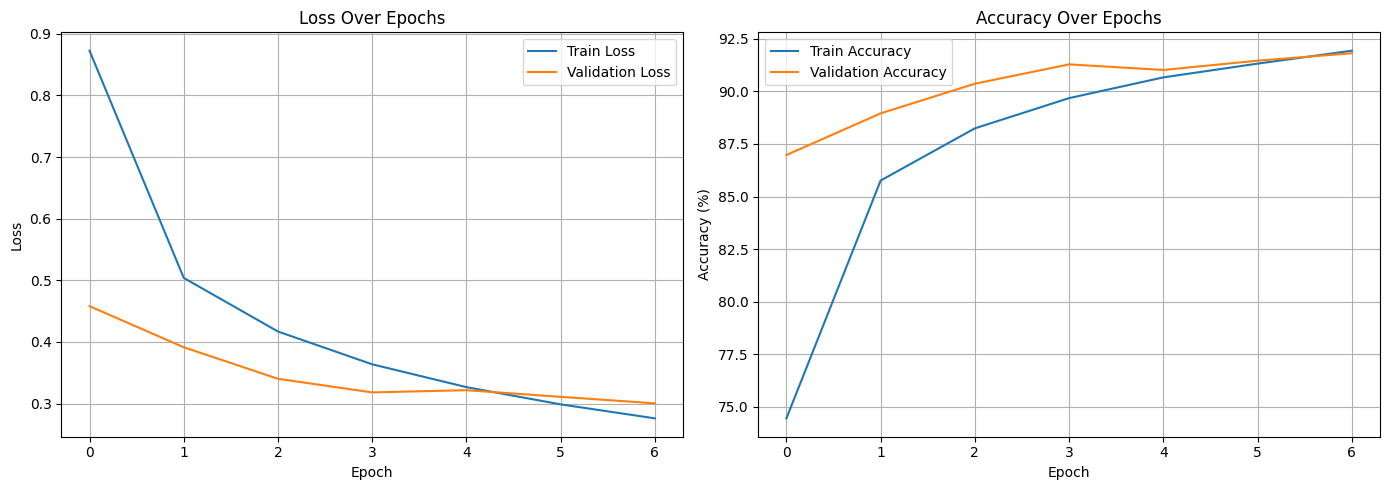

In [22]:
#defining the training function to train the model
#this function will take the model, dataloader, optimizer, loss function, and number of epochs as input and will perform the training loop
#as well as plot the training and validation loss and accuracy
def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=5):
    
    #tracks loss and accuracy for each epoch
    train_loss_history = []
    train_acc_history = []
    dev_loss_history = []
    dev_acc_history = []

    #training loop
    for epoch in range(epochs):
        model.train()  #set the model to training mode

        #initializing loss and accuracy trackers
        total_loss = 0
        correct = 0
        total = 0

        #iterating through the training data
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            #forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #update trackers
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        #average train loss and accuracy
        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = correct / total * 100

        #validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in dev_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / len(dev_loader)
        val_accuracy = val_correct / val_total * 100

        #record everything
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(train_accuracy)
        dev_loss_history.append(avg_val_loss)
        dev_acc_history.append(val_accuracy)

        #print epoch summary
        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    #plotting
    plt.figure(figsize=(14, 5))

    #loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(dev_loss_history, label='Validation Loss')
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    #accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(dev_acc_history, label='Validation Accuracy')
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

#training the model
train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=7)

# Evaluating the model


Accuracy: 91.81%


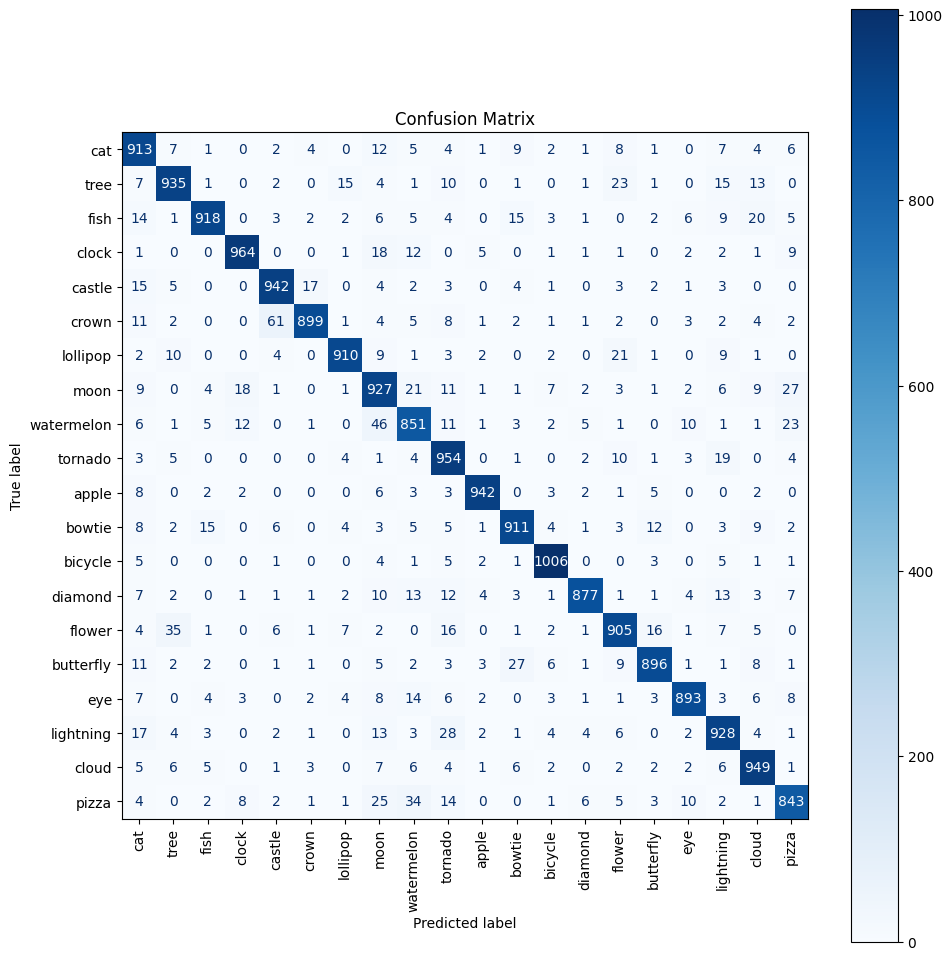

91.815

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#function to evaluate the model on the dev/test set
#this function will take the model, dataloader, and device as input and will perform the evaluation loop
#it will also plot the confusion matrix for better understanding of the model's performance
def evaluate_model(model, dataloader, device):
    
    model.eval() #set model to evaluation mode

    all_preds = [] #store all predicted labels
    all_labels = [] #store all true labels

    #initializing accuracy trackers
    correct = 0
    total = 0

    with torch.no_grad(): #no gradient computation needed
        #iterating through the test data
        for images, labels in dataloader:
            #move images and labels to the device
            images, labels = images.to(device), labels.to(device)

            #forward pass
            outputs = model(images)

            #getting the predicted class indices
            preds = outputs.argmax(dim=1)

            #store predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            #count the number of correct predictions
            correct += (preds == labels).sum().item()
            #count the total number of samples in the batch
            total += labels.size(0)

    #calculating accuracy
    accuracy = 100 * correct / total
    #printing the accuracy
    print(f"\nAccuracy: {accuracy:.2f}%")

    #computing the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    #plotting the matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap='Blues', ax=ax, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return accuracy

#evaluating the model on the dev set
evaluate_model(model, dev_loader, device)

## Testing how the model works by visualizing its predictions on one sample

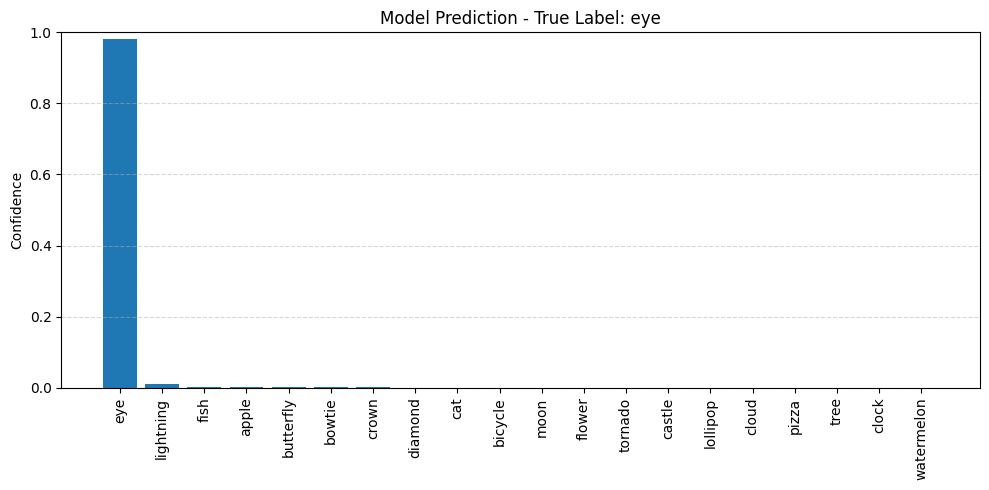

In [24]:
def evaluate_one_sample(model, dataloader, device, class_names):
    """
    Runs the model on one image from the test set, and shows the class probabilities
    """

    model.eval() #set model to evaluation mode

    #get one batch from the dataloader
    image, label = next(iter(dataloader))
    #image is a batch of images, so we take the first one
    image = image[0].unsqueeze(0).to(device)
    #label is a batch of labels, so we take the first one
    label = label[0].item()

    with torch.no_grad(): #no gradient computation needed
        #forward pass
        output = model(image)
        #output is the raw scores for each class, we need to apply softmax to get probabilities
        probs = torch.softmax(output, dim=1)

    #probs is a tensor of shape [1, num_classes], we need to squeeze it to get [num_classes]
    probs = probs.squeeze().cpu().numpy()

    #map class names to probabilities
    class_probs = list(zip(class_names, probs))

    #sort descending by confidence
    class_probs.sort(key=lambda x: x[1], reverse=True)

    #plot all class probabilities as a bar chart
    labels, values = zip(*class_probs) #splits class names and probabilities into two separate lists
    plt.figure(figsize=(10, 5))
    plt.bar(labels, values)
    plt.xticks(rotation=90)
    plt.title(f"Model Prediction - True Label: {class_names[label]}")
    plt.ylabel("Confidence")
    plt.ylim(0, 1)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

evaluate_one_sample(model, dev_loader, device, label_names)


Accuracy: 91.83%


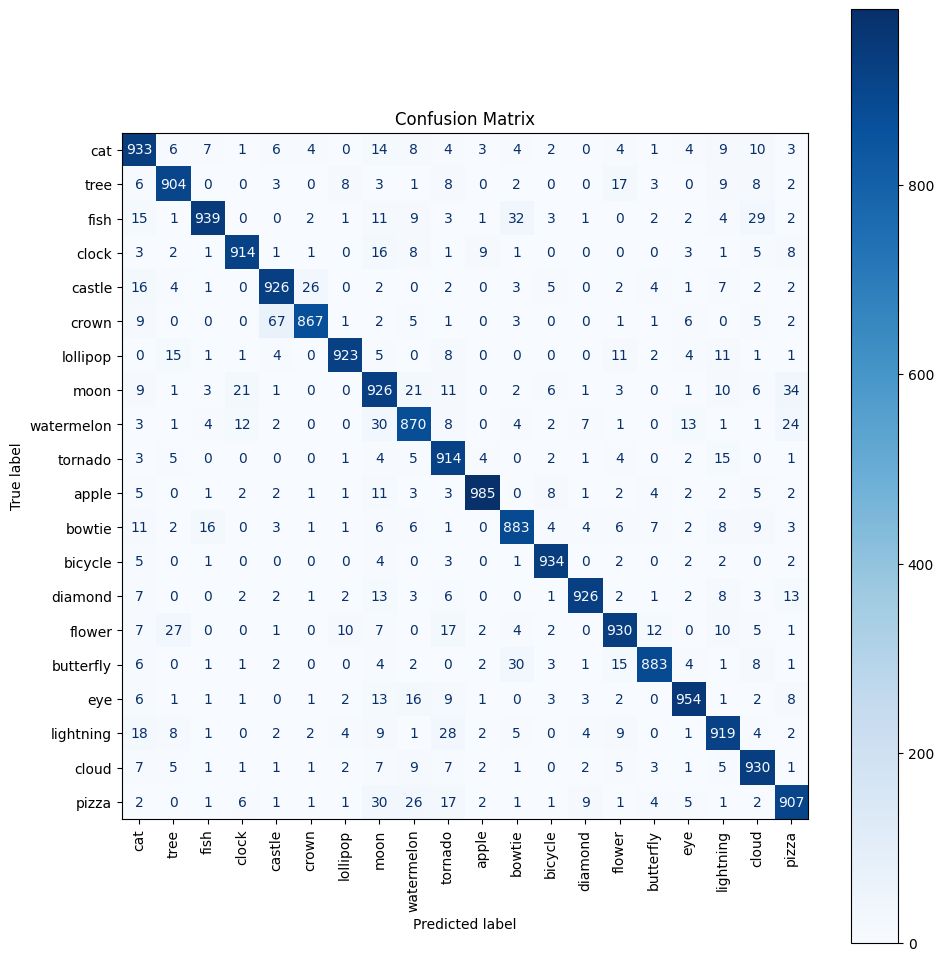

91.835

In [25]:
#evaluating the model on the test set
evaluate_model(model, test_loader, device)

# Saving the Model

In [27]:
#save model weights to a file
torch.save(model.state_dict(), "model1.pth")